<a href="https://colab.research.google.com/github/aruaru0/HuBmap/blob/main/%E3%83%9E%E3%83%BC%E3%82%B8_b5_train_segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SegFormer Train

In [ ]:
!nvidia-smi

Wed Sep 14 12:16:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# %%capture
# !pip install wandb --upgrade

In [ ]:
# !cp /content/drive/MyDrive/Kaggle/netrc ~/.netrc

In [ ]:
# import wandb
# wandb.login()

## kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/datas/kaggle.json  ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c hubmap-organ-segmentation

100% 5.76G/5.78G [02:24<00:00, 61.4MB/s]
100% 5.78G/5.78G [02:25<00:00, 42.8MB/s]


In [ ]:
# !mkdir hubmap
!unzip /content/hubmap-organ-segmentation.zip -d hubmap >/dev/null

In [ ]:
!pip install pytorch-lightning
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 707 kB 3.8 MB/s 
     |████████████████████████████████| 419 kB 57.5 MB/s 
     |████████████████████████████████| 5.9 MB 65.0 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.1 MB/s 
     |████████████████████████████████| 365 kB 71.3 MB/s 
     |████████████████████████████████| 

In [ ]:
!pip install staintools
!pip install spams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14075 sha256=2b9ece3f2a01db8958b6cc48d8a3ed329345193152619958cc7c3bb4ed2e0492
  Stored in directory: /root/.cache/pip/wheels/9b/ed/74/9d36d40854e911d8e2d2d28d7b67e37e9f176f913ecf34f813
Successfully built staintools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp37-cp37m-linux_x86_64.whl size=3236657 sha256=666eeb7d459bd03b7503d1699a81033551cfff8a99e53ec53c38a73fa3c4465f
  Stored in directory: /root/.cache/pip/wheels/5e/92/17/e718e0e26bfcdd7e81afcf874ac2bc599dd7dd7f3ad78f9d76
Successfully built spams


In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

## Start code

In [ ]:
# import wandb
# wandb.init(project="HuBMAP-SegFormer")
NFOLD = 3
FOLD = 2

In [ ]:
%load_ext tensorboard

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ConstantLR, LinearLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from timm import create_model

import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import albumentations as albu
import random

import pandas as pd

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

In [ ]:
#https://www.kaggle.com/code/pestipeti/decoding-rle-masks/notebook
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle, shape=(3000,3000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

##  load test data

In [ ]:
SEED = 2022
BATCH_SIZE = 4
Gradient_Accumulation_Step = 7

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [ ]:
DATA_DIR = './hubmap'

WIDTH, HEIGHT = 768, 768

model_path = '/content/drive/MyDrive/datas/HuBMAP/model-b5-fold{}.pth'.format(FOLD)
MODEL_NAME = "nvidia/mit-b5"
# MODEL_NAME = "nvidia/segformer-b3-finetuned-ade-512-512"



#
# nvidia/segformer-b0-finetuned-ade-512-512
# nvidia/segformer-b1-finetuned-ade-512-512
# nvidia/segformer-b2-finetuned-ade-512-512
# nvidia/segformer-b3-finetuned-ade-512-512
# nvidia/segformer-b4-finetuned-ade-512-512
# nvidia/segformer-b5-finetuned-ade-640-640
# https://huggingface.co/models?other=segformer&sort=downloads&search=nvidia%2Fsegformer+finetuned
#
df = pd.read_csv(DATA_DIR + '/train.csv')

In [ ]:
# df = df[df['organ']=='lung'].reset_index()
df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [ ]:
# class2idx = dict([(name,i+1) for i, name in enumerate(df.organ.unique())])
# class2idx['none'] = 0
# idx2class = dict([(class2idx[name], name) for name in class2idx])

class2idx = {'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0}
idx2class = {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'}

class2idx, idx2class

({'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0},
 {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'})

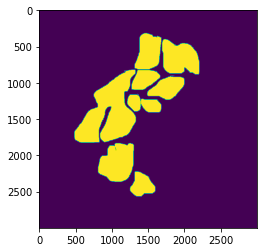

In [ ]:
idx = 0
height, width, rle = df['img_height'][idx], df['img_width'][idx], df['rle'][idx]
mask = rle2mask(rle, shape=(height, width))
plt.imshow(mask)

In [ ]:
from sklearn.model_selection import StratifiedKFold

df['fold'] = 0

skf = StratifiedKFold(n_splits=NFOLD)
for i, index in enumerate(skf.split(df.id, df.organ)):
  train_index, test_index = index
  # print("train_index:", train_index, "test_index:", test_index)
  # df['fold'][test_index] = i
  df.loc[test_index, 'fold'] = i

df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,0
...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,2
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,2
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,2
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,2


## Utils

### augumentation

In [ ]:
import staintools

In [ ]:
class Stain(albu.ImageOnlyTransform):
    def __init__(
        self,
        method='vahadane', sigma1=0.2, sigma2=0.2,
        always_apply=False,
        p=0.5,
    ):
        super(Stain, self).__init__(always_apply, p)
        self.method = method
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.augmentor = staintools.StainAugmentor(method=method, sigma1=sigma1, sigma2=sigma2)

    def apply(self, img, **params):
        self.augmentor.fit(img)
        return self.augmentor.pop().astype(int)

    def get_params(self):
        return {
        }

    def get_transform_init_args_names(self):
        return ("brightness_limit", "contrast_limit", "brightness_by_max")

In [ ]:
# ----- set0
def get_training_augmentation_set0(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p,
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
    ], p=p)
# ---- set1
def get_training_augmentation_set1(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        # albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p,
        #                  border_mode=cv2.BORDER_REFLECT),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=p,
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.ChannelShuffle(p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
    ], p=p)


In [ ]:
def get_training_augmentation3(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p,
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            # albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
        # albu.CoarseDropout (max_holes=50, max_height=16, max_width=16, p=p)
    ], p=p)

# def get_training_augmentation3(p=0.5):
#     return albu.Compose([
#         albu.Sequential([
#           albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
#           albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
#         ], p=p),
#         albu.HorizontalFlip(p=p),
#         albu.VerticalFlip(p=p),
#         albu.RandomRotate90(p=p),
#         albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p,
#                          border_mode=cv2.BORDER_REFLECT),
#         # albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=p,
#         #                  border_mode=cv2.BORDER_REFLECT),
#         # albu.OneOf([
#         #     albu.OpticalDistortion(p=1),
#         #     albu.GridDistortion(p=1),
#         #     albu.IAAPiecewiseAffine(p=1),
#         # ], p=p),
#         albu.OneOf([
#             albu.ChannelShuffle(p=1),
#             albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
#             albu.CLAHE(clip_limit=2, p = 1),
#             albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
#             albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
#         ], p=p),
#         albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
#         albu.CoarseDropout (max_holes=50, max_height=16, max_width=16, p=p)
#     ], p=p)


In [ ]:
def get_training_augmentation2(p=1.0):
    return albu.Compose([
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
        albu.RandomRotate90(),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        albu.OneOf([
            albu.OpticalDistortion(p=0.3),
            albu.GridDistortion(p=.1),
            albu.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        albu.OneOf([
            # albu.HueSaturationValue(10,15,10),
            albu.CLAHE(clip_limit=2),
            albu.RandomBrightnessContrast(),
        ], p=0.3),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3)
    ], p=p)

def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
        albu.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_grayaug():
    train_transform = [
        albu.ToGray(p=1.0),
    ]
    return albu.Compose(train_transform)

# def get_validation_augmentation():
#     """画像のshapeが32で割り切れるようにPaddingするための関数"""
#     test_transform = [
#         albu.PadIfNeeded(384, 480)
#     ]
#     return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# 可視化用の関数
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## dataset

In [ ]:
from transformers import SegformerFeatureExtractor

mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))


# 1. torch.utils.data.Datasetを継承したDataset classを定義
class Dataset(torch.utils.data.Dataset):
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
    #            'tree', 'signsymbol', 'fence', 'car',
    #            'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            image_dir,
            df, # ファイル名一覧
            # classes=None, # 推論対象のクラス
            augmentation=None, # augmentation用関数
            preprocessing=None, # 前処理用関数
            width = 768,
            height = 768,
    ):
        self.image_dir = image_dir
        self.df = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.width = width
        self.height = height
        self.feature_extractor = SegformerFeatureExtractor(MODEL_NAME , reduce_labels=False, size=(width, height))

    # 3. 学習用データ(image)と特徴(mask)を返す__getitem__メソッドを作成
    def __getitem__(self, i):
        # データの読み込み
        fname = "{}/{}.tiff".format(self.image_dir,self.df['id'][i])
        # print(fname)
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rle, w, h = self.df['rle'][i], self.df['img_width'][i], self.df['img_height'][i]
        idx = class2idx[self.df['organ'][i]]
        mask = rle2mask(rle, shape = (w, h))
        # print(self.df['organ'][i], idx)

        image = cv2.resize(image, (self.width, self.height))
        mask = cv2.resize(mask, (self.width, self.height)) * idx

        # augmentation関数の適用
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # print("image", image.shape)
        # # return image, mask
        # image = (image/255 - mean)/std

        # return img2tensor(image),torch.tensor(mask), idx
        # return image, mask
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

    # 4. データセットの長さを返す__len__を作成
    def __len__(self):
        return len(self.df)

torch.Size([3, 768, 768])


tensor([0, 1])

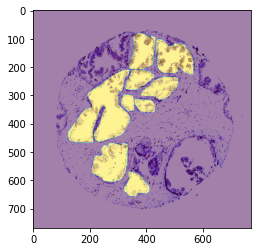

In [ ]:
IMAGE_DIR = './hubmap/train_images'
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), width=WIDTH, height=HEIGHT)
input = train_dataset[0]
print(input['pixel_values'].shape)
plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
plt.imshow(input['labels'], alpha=0.5)
input['labels'].unique()

In [ ]:
input

{'pixel_values': tensor([[[2.0777, 2.0605, 2.0605,  ..., 2.0777, 2.0605, 2.0777],
         [2.0605, 2.0777, 2.0605,  ..., 2.0777, 2.0777, 2.0777],
         [2.0605, 2.0434, 2.0777,  ..., 2.0777, 2.0777, 2.0777],
         ...,
         [2.0777, 2.0605, 2.0777,  ..., 2.0605, 2.0777, 2.0777],
         [2.0605, 2.0605, 2.0777,  ..., 2.0777, 2.0777, 2.0777],
         [2.0605, 2.0777, 2.0777,  ..., 2.0605, 2.0777, 2.0605]],

        [[2.2360, 2.2185, 2.2185,  ..., 2.2535, 2.2360, 2.2535],
         [2.2185, 2.2535, 2.2535,  ..., 2.2535, 2.2535, 2.2360],
         [2.2360, 2.2360, 2.2360,  ..., 2.2535, 2.2360, 2.2535],
         ...,
         [2.2535, 2.2535, 2.2360,  ..., 2.2535, 2.2535, 2.2535],
         [2.2535, 2.2535, 2.2360,  ..., 2.2535, 2.2535, 2.2535],
         [2.2535, 2.2535, 2.2535,  ..., 2.2535, 2.2535, 2.2535]],

        [[2.4657, 2.4308, 2.4483,  ..., 2.4657, 2.4308, 2.4657],
         [2.4657, 2.4657, 2.4657,  ..., 2.4657, 2.4657, 2.4657],
         [2.4483, 2.4308, 2.4483,  ..., 2

234


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


0 torch.Size([3, 768, 768])


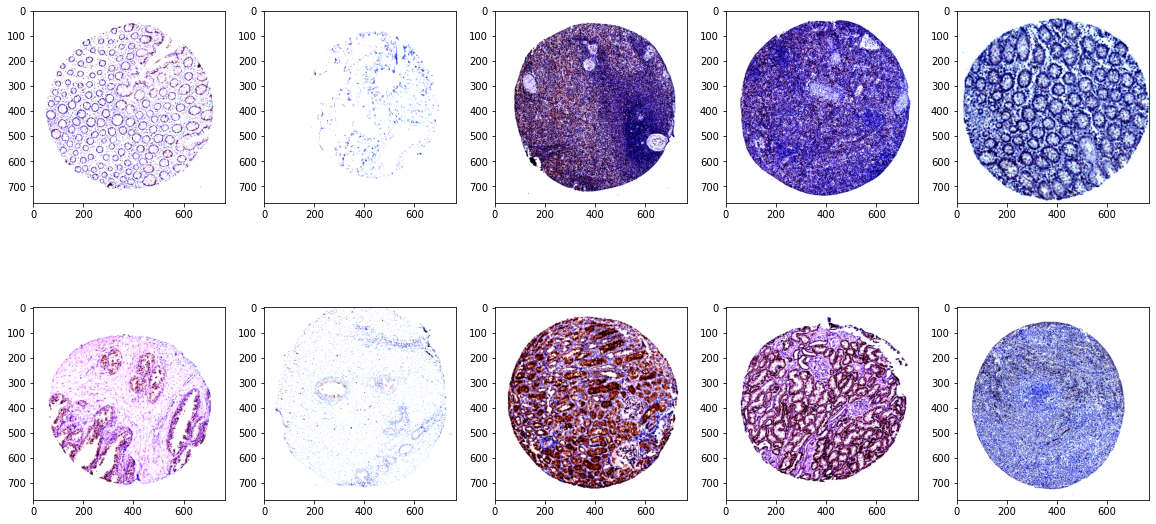

In [ ]:
# # # データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != 0].reset_index(),
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(),
                        )

plt.figure(figsize=(20, 10))

print(train_dataset.__len__())
for i in range(10) :
  input = train_dataset[i]
  print(idx, input.pixel_values.shape)
  plt.subplot(2, 5, i+1);
  plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
  # plt.imshow(input['labels'], alpha=0.5)
plt.show()

In [ ]:
from torch.utils.data import DataLoader
# CLASSES = ['car']


# データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(),
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(p=0.9),
                        )
# train_dataset = Dataset(IMAGE_DIR, df.reset_index(),
#                         width=WIDTH, height=HEIGHT,
#                         augmentation=get_training_augmentation3(p=0.9),
#                         )

valid_dataset = Dataset(
    IMAGE_DIR, df[df['fold'] == FOLD].reset_index(),
    width=WIDTH, height=HEIGHT,
    augmentation=None,
)

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

0


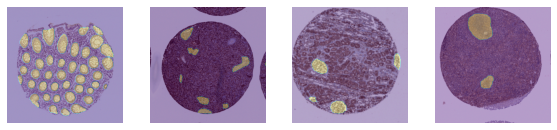

In [ ]:
row, col = 8, 8
plt.figure(figsize=(20,20))

for inputs in train_loader:
  print(idx)
  data = inputs['pixel_values']
  mask = inputs['labels']
  for i in range(BATCH_SIZE) :
    plt.subplot(col, row, i+1)
    x = data[i].permute(1,2,0)
    plt.imshow((x-x.min())/(x.max()-x.min()))
    plt.imshow(mask[i], alpha=0.3)
    plt.axis('off')
  # print(data.shape)
  break

## ここまで前処理

In [ ]:
from transformers import SegformerForSemanticSegmentation
# define model
# model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
#                                                          num_labels=len(class2idx),
#                                                          id2label=idx2class,
#                                                          label2id=class2idx,
#                                                          ignore_mismatched_sizes=True,
# )

In [ ]:
# # model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
# model_path_last = '/content/drive/MyDrive/datas/HuBMAP/last-fold{}.pth'.format(FOLD)
# model.load_state_dict(torch.load(model_path_last))

In [ ]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [ ]:
test_df = df[df['fold'] == FOLD].reset_index()

def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice

def valid(model2) :
  model2.eval()
  dice = 0.0
  loss = 0.0
  for i in tqdm(range(len(test_df))) :
    id = test_df.id[i]
    fname = "/content/hubmap/train_images/{}.tiff".format(id)
    image = Image.open(fname)
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.cuda()

    # print(pixel_values.shape)

    organ = test_df.organ[i]
    idx = class2idx[organ]

    rle = test_df.rle[i]
    height, width = test_df.img_height[i], test_df.img_width[i]
    gt = rle2mask(rle, shape = (height, width))
    gt2 = cv2.resize(gt, pixel_values.shape[-2:]) * idx

    label = torch.tensor(gt2).unsqueeze(0).long().cuda()

    # print(label.shape)

    with torch.no_grad():
      outputs = model2(pixel_values=pixel_values, labels=label)
      loss += outputs.loss.item()
      # print(outputs.loss, loss)
      upsampled_logits = nn.functional.interpolate(outputs['logits'],
                  # size=image.size[::-1], # (height, width)
                  (height, width),
                  mode='bilinear',
                  align_corners=False)
      mask = upsampled_logits.argmax(dim=1)[0]
      mask[mask != idx] = 0
      mask[mask == idx] = 1


    dice += dice_coef(mask.cpu().numpy(), gt)
  return dice/len(test_df), loss/len(test_df)

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
# from tqdm.notebook import tqdm
# from tqdm import tqdm
from fastprogress.fastprogress import  progress_bar as tqdm

from PIL import Image
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))


## スコアチェック


In [ ]:
import glob
PATH = "/content/drive/MyDrive/datas/HuBmap-segformer/*fold{}.pth".format(FOLD)
files = glob.glob(PATH)
files

['/content/drive/MyDrive/datas/HuBmap-segformer/last-fold2.pth',
 '/content/drive/MyDrive/datas/HuBmap-segformer/model-b5-fold2.pth',
 '/content/drive/MyDrive/datas/HuBmap-segformer/epoch100-fold2.pth',
 '/content/drive/MyDrive/datas/HuBmap-segformer/epoch150-fold2.pth']

In [ ]:
def read_model(file) :
  model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
                                                          num_labels=len(class2idx),
                                                          id2label=idx2class,
                                                          label2id=class2idx,
                                                          ignore_mismatched_sizes=True,
  )
  model.load_state_dict(torch.load(file))
  model.cuda()
  model.eval()
  return model

def copy_params(model1, model2) :
  model1.load_state_dict(model2.state_dict())
  return model1

def sum_model_params(modelA, modelB):
    """ modelA + modelB """
    sdA = modelA.state_dict()
    sdB = modelB.state_dict()
    for key in sdA:
        sdA[key] = (sdA[key] + sdB[key])
    modelA.load_state_dict(sdA)
    return modelA

def multi_model_params(model, a):
    """ a * model """
    sd = model.state_dict()
    for key in sd:
        sd[key] = sd[key] * a
    model.load_state_dict(sd)
    return model

In [ ]:
models = []
for file in files :
  models.append(read_model(file))

new_model = read_model(files[0])


len(models)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linea

4

In [ ]:
# base_score = []
# for model in models :
#   base_score.append(valid(model))

# print(base_score)
# max_score = max([x for x, y in base_score])
# max_score

In [ ]:
# new-fold1やり直し

In [ ]:
n = len(models)

model_path = "/content/drive/MyDrive/datas/HuBMAP/merge-fold{}.pth".format(FOLD)

max_score = 0
for bit in range(1,1<<n) :
  pat = []
  for i in range(len(models)) :
    if (bit>>i)%2 == 0 : pat.append(0)
    else: pat.append(1)

  cnt = 0
  for i, e in enumerate(pat) :
    if e == 1 :
      if cnt == 0 :
        new_model = copy_params(new_model, models[i])
      else :
        new_model = sum_model_params(new_model, models[i])
      cnt += 1

  new_model = multi_model_params(new_model, 1/cnt)
  new_model.eval()

  dice, loss = valid(new_model)
  print(pat, dice, loss)
  if dice > max_score :
    print("Update!!")
    max_score = dice
    torch.save(new_model.state_dict(), model_path)



[1, 0, 0, 0] 0.7645103886069159 0.12403650638750857
Update!!


[0, 1, 0, 0] 0.7732580504340272 0.1212508974230697
Update!!


[1, 1, 0, 0] 0.7713550878930734 0.12150596961394972


[0, 0, 1, 0] 0.7492906884150086 0.1134967671162011


[1, 0, 1, 0] 0.7592286263731879 0.11638874171548483


[0, 1, 1, 0] 0.7613419736230022 0.11677299570053434


[1, 1, 1, 0] 0.7648190045053416 0.11764595470327534


[0, 0, 0, 1] 0.7656732042985334 0.1271983337485128


[1, 0, 0, 1] 0.7663639009733367 0.12395168423481509


[0, 1, 0, 1] 0.7695613401940975 0.12370420494077043


[1, 1, 0, 1] 0.7696258559920729 0.122688947018618


[0, 0, 1, 1] 0.7575418778035933 0.11924189177508919


[1, 0, 1, 1] 0.7619060714175682 0.1192888340427198


[0, 1, 1, 1] 0.7636899724499856 0.11963493606616926


[1, 1, 1, 1] 0.7656576515886534 0.11957697577686964


In [ ]:
max_score

0.7732580504340272

In [ ]:


# pat = [0,1,1,1]

# cnt = 0
# for i, e in enumerate(pat) :
#   if e == 1 :
#     if cnt == 0 :
#       new_model = copy_params(new_model, models[i])
#     else :
#       new_model = sum_model_params(new_model, models[i])
#     cnt += 1

# new_model = multi_model_params(new_model, 1/cnt)

# dice, loss = valid(new_model)